# Example notebook for Proteus operations

### Author

Boris Nedyalkov, Quantum Computing Lab, IFAE, Barcelona

#### **In this notebook you will learn how to:**

* Import all the libraries one needs
* Set the working parameters of the machine
* Initialize the machine
* Create waveforms
* Download the waveforms to the Proteus
* Create a tasktable (sequences of pulses)
* Readout the signal [==UNDER DEVELOPEMENT==]
* Process the signal readout data [==UNDER DEVELOPEMENT==]

### Import some generic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import os

srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)

# These are the Tabor developers' libraries, they allow us to I/O interface with the Proteus
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

### Import our homemade libraries

In [2]:
import initializers  # this library contains intialization functions for the Proteus 

import pulse_lib # this library contains all the types of pulses, one can add here a new type of pulse if needed
import tasks # this library contains all the types of basic tasks, new ones can be added if need arises
import readers # this library contains all the readout functions

import helpers # this library contains auxillary functions

### Set the parameters of the machine

In [3]:
SCLK = 1000e6  ### sampling clock rate of the generator (AWG)
DUC_INTERP = 1  ### the DUC interpolator mode  

### Initialize the machine

In [4]:
# get the DAC mode, range, Serial port #, the data type of the system (8 or 16bit), and the instrument handle
dac_mode, max_dac, sid, data_type, inst = initializers.connection_func() # Make sure the Model name is P9484M, that the name of our module


=========CONNECTING=========
process id 21540
Connected to: Tabor Electronics,P9484M,000000220642,1.118.0
Model: P9484M
===CONNECTION ESTABLISHED===

===SYSTEM'S INFORMATION===
DAC waveform format: 16 bits-per-point
Max DAC wave-point level: 65535
Half DAC wave-point level: 32767.0
Number of channels: 4
Max segment number: 65536
Available memory per DDR: 8,581,545,984 wave-bytes
==========READY============


### Initialize the channels

In [ ]:
# initialize channel 1
channel_numb = 1
initializers.initialization_func(channel_numb, inst, SCLK)

# initialize all the channels
# for i in range(0,4):  
#     channel_numb = i + 1
#     ml.initialization_func(channel_numb, inst, SCLK)  


===INITIALIZATION OF CHANNEL 1===  -->  ===DONE===
ERRORS: 0, no error


### Define some pulse shapes

In [6]:
pulse = pulse_lib.Pulse(SCLK, DUC_INTERP, show_plot = True)

Defining the sinus and the blank signal. After that we convert them to 16bit numbers (the Proteus takes its input in that format)

Note: A !WARNING! message may come if the data chunk representing the form doesn't have the right length of bytes.
An automatic script to convert it to the closest right length will engage and fix this. The resulting length of the waveform in bytes will be given after.

original seglen: 10000.0

!WARNING! The segment of the defined signal (10000.0 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

formated seglen: 9984
The blank singnal is with time width: 2.048e-06


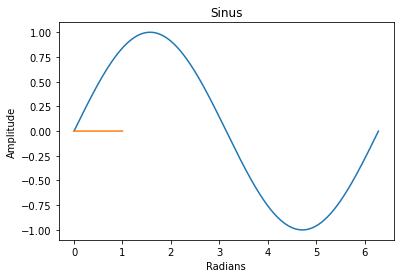

In [7]:
sin_f = pulse.simple_sin(amplitude = 1, frequency = 100000)  ### creating a sinus shape, frequency is in Hz

blank= pulse.blank_signal()

sin_f = helpers.digital_conv_func(sin_f, max_dac, data_type) ### converting the signal from float format array to a binary format array
blank = helpers.digital_conv_func(blank, max_dac, data_type)

@ Defining the parameters and creating a gaussian pulse. After that we convert the signal array to 16bit format (the Proteus takes its input in that format)

period = 1000.0[ns]
sigma = 3400.0[ns]
sigma_num = 3400.0 datapoints 
5 3400.0 17000.0
Gaussian Segement length = 17000 datapoints

Gaussian Segement length (in time) = 17000.0 [ns]]

!WARNING! Sigma is comparable to the period of the oscillation


!WARNING! The segment of the defined signal (17000 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

Gaussian frequency = 1.0[Mhz]


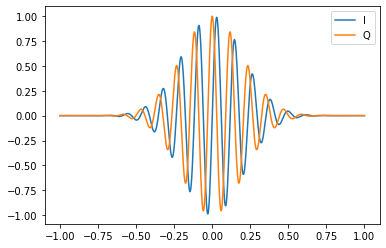

In [8]:
frequency = 10e5 ### frequency of the oscillation
sigma = 340e-08  ### make it bigger then the period of the oscillation 
width_over_sigma = 5    # time width of the gaussian pulse, a.k.a. how many sigmas wide is the pulse, for example - width = [5*sigma], by 
amplitude = 1

gauss_signal_i = pulse.gaussian_pulse (amplitude, sigma, width_over_sigma, frequency)[0]

gauss_signal_i = helpers.digital_conv_func(gauss_signal_i, max_dac, data_type)

@ Same thing but with the sinus pulse

period = 1000.0[ns]
Sine segement length = 12999 datapoints

Sine segement length (in time) = 13000.0 [ns]]

!WARNING! The segment of the defined signal (12999 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

Signal frequency = 1.0[Mhz]


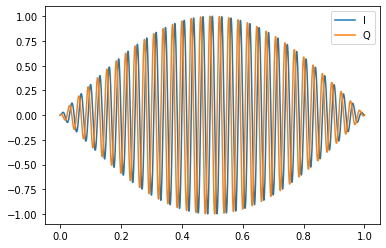

In [9]:
frequency = 1e6 ### frequency of the oscillation
width = 13e-6
amplitude = 1

sin_signal_i = pulse.sin_pulse (amplitude, width, frequency)[0]

sin_signal_i = helpers.digital_conv_func(sin_signal_i, max_dac, data_type)

### Downloading some wave shapes onto the Proteus

In [10]:
wave = gauss_signal_i
wave2 = sin_f
wave3 = blank
wave4 = sin_signal_i

In [ ]:
# initialize the channel
channel_numb = 1
initializers.initialization_func(channel_numb, inst, SCLK)

@ When we download the signal onto the proteus we choose a segment number to assign to it, by this number we will refer to the signal later.

In [27]:
# download signal to an approprate 'channel' and 'segment of the channel'
helpers.download_func (inst, wave, channel = 1, segment = 1)
helpers.download_func (inst, wave2, channel = 1, segment = 2)
helpers.download_func (inst, wave3, channel = 1, segment = 3)
helpers.download_func (inst, wave4, channel = 1, segment = 4)

wave size: 16960
0, no error
wave size: 9984
0, no error
wave size: 2048
0, no error
wave size: 12992
0, no error


### Let us now define a tasktable (as sequence of pulses and actions)

In [12]:
task = tasks.Task(inst)

In [13]:
task.simple_tasker (tasklen = 2, channel = 1)

Current task: 1
Next task will be task: 2
Current task: 2
Next task will be task: 1
0, no error


In [14]:
########################################## DEBUGGING ZONE ##########################################

In [15]:
# ml.simple_sequence_task (inst, channel = 1, time_delay = 15, segment_pulse1 = 1, segment_pulse2 = 4, segment_time_delay = 3)

In [17]:
#########################################

In [28]:
def new_simple_sequence_task (inst, channel, time_delay, segment_pulse1 = int, segment_pulse2 = int, segment_time_delay = int):
    
    """
    This is simple quantum bit sequance pulser task. It sends one pulse, waits for some time and then sends some other pulse. 
    This is a TEMPLATE tasktable. To be used for more elaborate qubit manipulation sequences.
    
    INPUTS:
    inst - the instance of inst
    channel - channel number
    segment1
    segment2
    segment-time-delay - this is the segment that one has assigned the "blank" signal to, it is used as an empty or a ""
        
    OUTPUTS:
        None
    """
    
    cmd = ':INST:CHAN {0}'.format(channel)
    inst.send_scpi_cmd(cmd )

    # what is the length of this task sequence
    cmd = ':TASK:COMP:LENG {0}'.format(3) ### SET TO 3, because of the 3 segments !!! INCREASE IF NEEDED !!!
    inst.send_scpi_cmd(cmd )
    
    ############################################### SUBROUTINE #####################################
    
    def subroutine (curr_task, segnb, tasklen, loops):

            cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
            inst.send_scpi_cmd(cmd)
            
            cmd = ':TASK:COMP:TYPE SING'
            inst.send_scpi_cmd(cmd)

            if curr_task == 1: 
                cmd = ':TASK:COMP:DTRigger ON'
                inst.send_scpi_cmd(cmd)

            if curr_task==tasklen:
                cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
                inst.send_scpi_cmd(cmd)
            else:
                cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
                print("Next task:",curr_task)
                inst.send_scpi_cmd(cmd)
                
            # # Trigger Digitizer  
            # cmd = ':TASK:COMP:DTR ON'
            # inst.send_scpi_cmd(cmd)

            # define the number of loops for the specific task
            cmd = ':TASK:COMP:LOOP {0}'.format(loops)
            inst.send_scpi_cmd(cmd)

            # name the segment of memory to take the signal to be tasked with the aformentioned parameters from
            cmd = ':TASK:COMP:SEGM {0}'.format(segnb)
            inst.send_scpi_cmd(cmd)
        
    ################################################################################################
    
#     # Trigger Digitizer  
#     cmd = ':TASK:COMP:DTR ON'
#     inst.send_scpi_cmd(cmd)
    subroutine (curr_task = 1, segnb = segment_pulse1, tasklen = 3, loops = 1)
#     subroutine (curr_task = 2, segnb = segment_time_delay, tasklen = 3, loops = time_delay)
#     subroutine (curr_task = 3, segnb = segment_pulse2, tasklen = 3, loops = 1)
    

    # write task to the machine
    cmd = ':TASK:COMP:WRIT'
    inst.send_scpi_cmd(cmd)
    print('Downloading Task table to channel {0}'.format(channel))

#     # define the operation mode
#     cmd = 'FUNC:MODE TASK'
#     inst.send_scpi_cmd(cmd)

    
#     # point to the channel
#     cmd = ':INST:CHAN {0}'.format(channel)
#     inst.send_scpi_cmd(cmd)

#     # start the output
#     cmd = ':OUTP ON'
#     inst.send_scpi_cmd(cmd)


    # see if any errors came up
    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)
    
    return None

###########################################################

new_simple_sequence_task (inst, channel = 1, time_delay = 15, segment_pulse1 = 1, segment_pulse2 = 4, segment_time_delay = 3)

# define the operation mode
cmd = 'FUNC:MODE TASK'
inst.send_scpi_cmd(cmd)

channel = 1
# point to the channel
cmd = ':INST:CHAN {0}'.format(channel)
inst.send_scpi_cmd(cmd)

# start the output
cmd = ':OUTP ON'
inst.send_scpi_cmd(cmd)


# see if any errors came up
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Next task: 1
0, no error
0, no error


In [29]:
#########################################

In [30]:
# Setup the digitizer in two-channel mode

# Clean memory 
inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')  ## !!!! try with and without this, when everything is running OK

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

inst.send_scpi_cmd(':DIG:MODE DUAL')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)


inst.send_scpi_cmd(':DIG:FREQ 2000MHZ')

# Set center frequency of channel 1 to 200MHz
DDC_NCO = 2e6
inst.send_scpi_cmd(':DIG:DDC:CFR1 {0}'.format(DDC_NCO))

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

# Enable capturing data from channel 1
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# # Select the internal-trigger as start-capturing trigger:
# inst.send_scpi_cmd(':DIG:TRIG:SOURCE CPU')  ###!!!!!!!!!!!!!!!!!!!!!!
# Select the task trigger as start-capturing trigger:
inst.send_scpi_cmd(':DIG:TRIG:SOURCE TASK1')  ###!!!!!!!!!!!!!!!!!!!!!!

# Set Trigger AWG delay to 0
inst.send_scpi_cmd(':DIG:TRIG:AWG:TDEL {0}'.format(0))  ##!!!!!!!!!!!!!! Don't know if it should be like this

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

#################
# # Enable capturing data from channel 2
# inst.send_scpi_cmd(':DIG:CHAN:SEL 2')
# inst.send_scpi_cmd(':DIG:CHAN:STATE ENAB')
# # Select the internal-trigger as start-capturing trigger:
# inst.send_scpi_cmd(':DIG:TRIG:SOURCE CPU')


0, no error
0, no error
0, no error
0, no error


In [54]:
# Allocate four frames of 4800 samples
numframes, framelen = 1, 10*4800
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
# (all the four frames in this example)
capture_first, capture_count = 1, numframes
cmd = ':DIG:ACQuire:FRAM:CAPT {0},{1}'.format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)


resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error


In [63]:
# Clean memory 
inst.send_scpi_cmd(':DIG:ACQ:ZERO:ALL')  ## !!!! try with and without this, when everything is running OK
time.sleep(1)

# Stop the digitizer's capturing machine (to be on the safe side)
inst.send_scpi_cmd(':DIG:INIT OFF')
time.sleep(1)
# Start the digitizer's capturing machine ###################### START CAPTURE
inst.send_scpi_cmd(':DIG:INIT ON')

# Generate 4 software-triggers
# for _ in range(capture_count):
#     inst.send_scpi_cmd(':DIG:TRIG:IMM') # this command forces a trigger event for the digitizer when trigger source is set to CPU
#     time.sleep(0.1) # more than  enough for capturing single frame
#     # Query the status
#     resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STATus?')
#     print(resp)
# print("Waiting to recive enter to generate trigger - press Enter to start trigger")
# input()

inst.send_scpi_cmd('*TRG')
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)
print()

time.sleep(10) # if we wait long enough time the machine captures a signal
resp = inst.send_scpi_query(':DIG:ACQuire:FRAM:STAT?')
print(resp)
print('captured {0} frames'.format(resp[6:]))
print()

# Stop the digitizer's capturing machine (to be on the safe side) ################# STOP CAPTURE
inst.send_scpi_cmd(':DIG:INIT OFF')

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error

1,1,0,1
captured 1 frames

0, no error


In [64]:
# Choose which frames to read (all in this example)
inst.send_scpi_cmd(':DIG:DATA:SEL ALL')

# Choose what to read 
# (only the frame-data without the header in this example)
inst.send_scpi_cmd(':DIG:DATA:TYPE FRAM')

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')

wavlen = num_bytes // 2

wav1 = np.zeros(wavlen, dtype=np.uint16)

rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, num_bytes)

# # Read the data that was captured by channel 2:
# inst.send_scpi_cmd(':DIG:CHAN:SEL 2')

# wav2 = np.zeros(wavlen, dtype=np.uint16)
# rc = inst.read_binary_data(':DIG:DATA:READ?', wav2, num_bytes)

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

Total size in bytes: 96000

0, no error


In [65]:
wav1[0]

2058

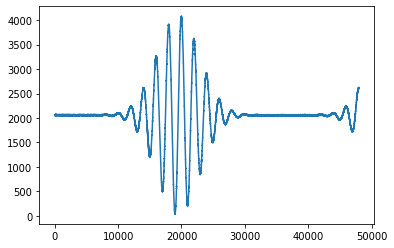

In [66]:
plt.plot(wav1)

In [68]:
#########################################

In [67]:
admin = TepAdmin()  ### decalring a shortcut to send SCPY commands to the machine
inst = admin.open_instrument(slot_id=sid)  ### decalring a shortcut to send SCPY commands to the machine

inst.close_instrument()
admin.close_inst_admin()

# ml.quitter(sid)

0